In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip.operators import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

For this notebook we are considering a single NV center with an applied magnetic field.  The parallel component of the field $B_{\parallel}$ is along the z-axis and the perpendicular component of the field $\vec{B_{perp}}$ is a circularly polarized microwave field with phase $\phi$, frequency $\omega_{mw}$, and amplitude $B_{\perp}(t)$

The Zeeman splitting term of the Hamiltonian is $H_{Zeeman} = \gamma_{nv} \vec{B} \cdot \vec{s}$ and after
 rotating into the microwave frequency, you get the following Hamiltonian, which is the drift Hamiltonian.  

$H_{RWA} = \Delta \hat{s}_{z} + \Omega (cos(\phi)\hat{s}_{x} + sin(\phi)\hat{s}_{y})$

The constants here are: $\Delta = \omega_{nv} - \omega_{mw}$ is the detuning, 

$\omega_{nv} = B_{\parallel}\gamma_{nv}$ is the NV resonant frequency,

$\Omega(t) = B_{\perp}\gamma_{nv}$ is the Rabi frequency,

and $\vec{s}$ are the Pauli operators for spin-1/2 

In [2]:
#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
#Delta
Omega = Bperpendicular * gammanv
Omega

#constants

f_fine_structure = 2.87e9
f_nuclear_quadrupole = -5.01e6
f_axial_magnetic_hyperfine = -2.14e6
f_transverse_magnetic_hyperfine = -2.7e6
g_factor_electron = 2.0028
gyromagnetic_constant_nuclear = 1.93297e7 / (2 * np.pi)
uB = physical_constants['Bohr magneton'][0]
uN = physical_constants['nuclear magneton'][0]    


We are going to work in frequency units, additionally we are going to divide all of the necessary constants by a factor of 1e9

In [3]:
#HB is the Zeeman term of the Hamiltonian,
#here is also where I divide Delta and Omega by a factor of a billion
#and round up to give it these values

h=1
Delta = 8
Omega = 18
HB= h*Delta*sigmaz() + h*Omega*sigmax() + h*Omega*sigmay() 
HB


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 8. +0.j 18.-18.j]
 [18.+18.j -8. +0.j]]

In [4]:
#Defining some terms so the hamiltonian is more clear
#Nuc terms are second qubit, spin=1
#Elec qubit is first qubit, spin=1

nuclear_spin = 1
electron_spin = 1
identity3 = identity(3)

sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN



After RWA, the Hamiltonian for the Zeeman term is a qubit, however the rest of the NV center is modelled as a qutrit.  We need to write this Hamiltonian as a qutrit for dimensions to match.

To do this, we take our desired 2x2 matrix and put it into the top left corner of a 3x3 matrix full of 0's

In [5]:
#writing out the Pauli x and y operators in a 3x3 matrix
SigmaZeemanx = Qobj([[0,1,0],[1,0,0],[0,0,0]])
SigmaZeemany = Qobj([[0,+1.j,0],[-1.j,0,0],[0,0,0]])

#since qubit one is the electric spin and qubit 2 is the nuclear spin, the operator needs to be the tensor product
#of the Pauli matrix of the electron and identity, that is done below
#these are the operators that can be tuned in the Hamiltonian via the control field
H_opsSigZeex = tensor(SigmaZeemanx,identity(3))
H_opsSigZeey = tensor(SigmaZeemany,identity(3))

#when you tensor things together in QuTIP in kepps the dimensions of the original object
#so changing the dims just tells it we can actually use this as a 9x1 and not 2 3x3s.
H_opsSigZeex.dims = [[9],[9]]
H_opsSigZeey.dims = [[9],[9]]

#making H_ops list           
H_ops = [Omega*H_opsSigZeex, Omega*H_opsSigZeey]

#Labels for the graph
H_labels = [r'$u_{x}$',
            r'$u_{y}$']


In [6]:
#manually writing a 2x2 x rotation into a 3x3 matrix and tensor producting with a 3x3 identity

phi = np.pi
rx = Qobj([
    [np.cos(phi/2) ,-1.j * np.sin(phi/2),0],
    [-1.j *np.sin(phi/2) ,np.cos(phi/2),0],
    [0,0,0]])

print(rx)
U=tensor(rx,identity(3))
U.dims=[[9],[9]]
print(U)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[6.123234e-17+0.j 0.000000e+00-1.j 0.000000e+00+0.j]
 [0.000000e+00-1.j 6.123234e-17+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


# Defining hamiltonian and constants 

In [7]:
#Here I redefine the constants in terms 1-4 of the Hamiltian, they're also just divided by a billion
f_transverse_magnetic_hyperfine = -0.003
f_nuclear_quardupole=0.005
f_axial_magnetic_hyperfine = -0.002
f_fine_structure = 3


#writing the Zeeman term of the Hamiltonian in terms of a 3x3 
HZ = [[8.0+0.j,18.0-18.j,0],[18.0+18.j,-8.0,0],[0,0,0]]
HZ =tensor(Qobj(HZ),identity(3))
print(HZ)



H1 = f_fine_structure * tensor((sigmazEsquared-(2/3)*identity3),identity3)

H2 = f_axial_magnetic_hyperfine * tensor(sigmazE,sigmazN) 

H3 = f_transverse_magnetic_hyperfine * (tensor(sigmaxE,sigmaxN)+tensor(sigmayE,sigmayN))

H4 = f_nuclear_quadrupole * tensor(tensor(identity3), (sigmazNsquared-(2/3)*identity3))
   
H0= HZ + H1 + H2 + H3 + H4
H0.dims=[[9],[9]] #changing dimensions again
print(H0) 



Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 8. +0.j  0. +0.j  0. +0.j 18.-18.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  8. +0.j  0. +0.j  0. +0.j 18.-18.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  8. +0.j  0. +0.j  0. +0.j 18.-18.j  0. +0.j  0. +0.j
   0. +0.j]
 [18.+18.j  0. +0.j  0. +0.j -8. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j 18.+18.j  0. +0.j  0. +0.j -8. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j 18.+18.j  0. +0.j  0. +0.j -8. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[-1.669991e+06 +0.j  0.000000e+00 +0.j

# Plot pulses

In [8]:
#doing GRAPE!
R = 500 #GRAPE iterations, 150 is a good number to test that it is doing what you want it to, 500 gives you decent fidelity
#T here is 1/Omega,  I just manually put the 18 in here in case it didn't like having a variable there?? 
T = 1/18
times = np.linspace(0, T, 1000)

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

result = cy_grape_unitary(U, H0, H_ops, R, times,u_start = u0 ,eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())



10.0%. Run time: 137.43s. Est. time left: 00:00:20:36
20.0%. Run time: 275.05s. Est. time left: 00:00:18:20
30.0%. Run time: 402.99s. Est. time left: 00:00:15:40
40.0%. Run time: 532.34s. Est. time left: 00:00:13:18
50.0%. Run time: 674.63s. Est. time left: 00:00:11:14
60.0%. Run time: 803.72s. Est. time left: 00:00:08:55
70.0%. Run time: 933.94s. Est. time left: 00:00:06:40
80.0%. Run time: 1067.89s. Est. time left: 00:00:04:26
90.0%. Run time: 1215.99s. Est. time left: 00:00:02:15
Total run time: 1350.06s


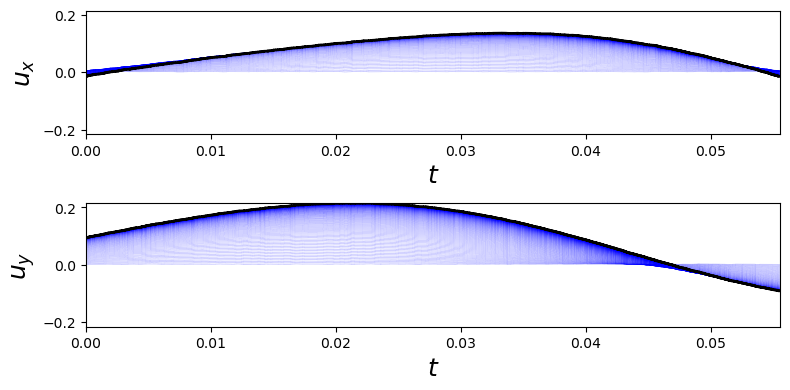

In [9]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

# Calcuate fidelity

In [10]:
# defining starting state, electron in (1,0) but written in the qutrit basis as (1,0,0), and nuclear spin as (1,0,0)

qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
startingstate=tensor(qubit1state,qubit1state) #initial state
startingstate.dims=[[9],[1]] #once again, changing dimensions
startingstate

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [11]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.-1.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


In [12]:
#printing resultant Unitary from the final iteration of GRAPE
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.        +0.j          0.        +0.j          0.        +0.j
   0.28725478-0.95785421j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j         -0.47879896-0.87792458j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.28715928-0.95788285j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.28726571-0.95785093j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.47879895-0.87792458j  0.        +0.j
   0.  

In [13]:
#printing the final state from the resultant Unitary
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.28726571-0.95785093j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]]


In [14]:
#finding density matrices and fidelity
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


0.9999999994755124